<a href="https://colab.research.google.com/github/Anastasia-Makarova/DATA_homeworks/blob/main/HW08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3500 # максимальне число епох                                          було 3000
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [ ]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [ ]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)

    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

    # Вихідний шар
    self.output_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=0)
    x = self.layer2(x, activation=0) #1
    output = self.output_layer(x, activation=1)

    return output

In [ ]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Місце для вашого коду
    y_pred_classes = tf.argmax(y_pred, axis=1, output_type=tf.int64)
    correct_predictions = tf.equal(y_pred_classes, tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [ ]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    grad = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(grad, trainable_variables))

In [ ]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss_value = cross_entropy(pred, batch_y)
        acc_value = accuracy(pred, batch_y)

        loss_history.append(loss_value.numpy())
        accuracy_history.append(acc_value.numpy())

        print(f"Step: {step}, Loss: {loss_value.numpy()}, Accuracy: {acc_value.numpy()}")


Step: 100, Loss: 298.7967834472656, Accuracy: 0.6640625
Step: 200, Loss: 215.26290893554688, Accuracy: 0.78515625
Step: 300, Loss: 146.0015411376953, Accuracy: 0.81640625
Step: 400, Loss: 197.11683654785156, Accuracy: 0.7734375
Step: 500, Loss: 140.9776611328125, Accuracy: 0.8359375
Step: 600, Loss: 64.52116394042969, Accuracy: 0.921875
Step: 700, Loss: 86.89059448242188, Accuracy: 0.90234375
Step: 800, Loss: 84.67181396484375, Accuracy: 0.91015625
Step: 900, Loss: 144.96060180664062, Accuracy: 0.82421875
Step: 1000, Loss: 117.29631042480469, Accuracy: 0.859375
Step: 1100, Loss: 105.19617462158203, Accuracy: 0.88671875
Step: 1200, Loss: 82.96351623535156, Accuracy: 0.921875
Step: 1300, Loss: 80.55833435058594, Accuracy: 0.90625
Step: 1400, Loss: 108.74630737304688, Accuracy: 0.88671875
Step: 1500, Loss: 70.44527435302734, Accuracy: 0.90234375
Step: 1600, Loss: 77.9003677368164, Accuracy: 0.8984375
Step: 1700, Loss: 91.79443359375, Accuracy: 0.91015625
Step: 1800, Loss: 84.7648620605468

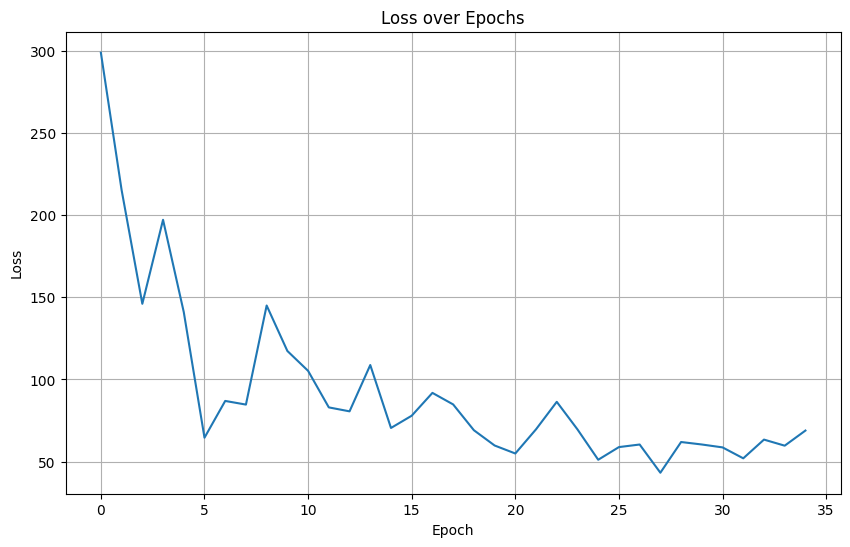

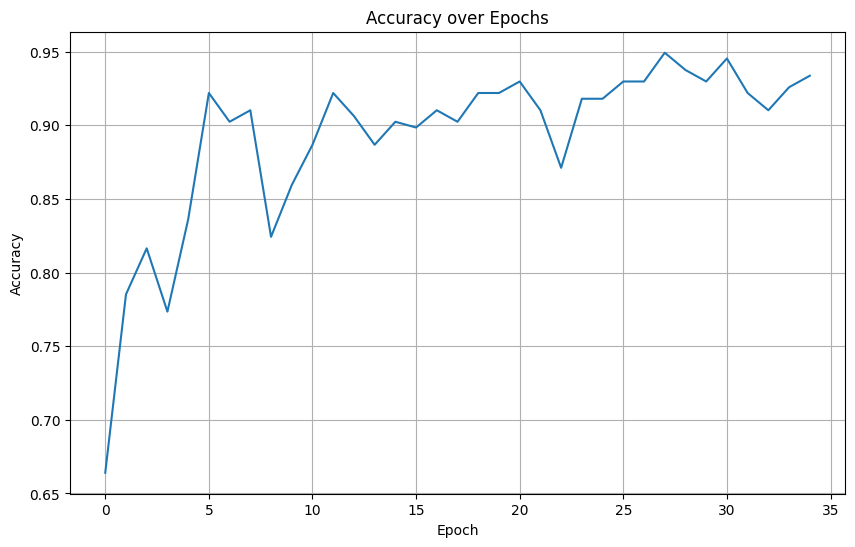

In [ ]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

# Виведіть графік функції втрат
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)


# Виведіть графік точності
plt.figure(figsize=(10, 6))
plt.plot(accuracy_history)
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [ ]:
# Обчисліть точність навченої нейромережі
test_loss = cross_entropy(neural_net(x_test), y_test)
test_acc = accuracy(neural_net(x_test), y_test)


print(f"Test Loss: {test_loss.numpy()}, Test Accuracy: {test_acc.numpy()}")
# Тестування моделі на тестових даних
test_pred = neural_net(x_test)
test_acc = accuracy(test_pred, y_test)
print(f"Test Accuracy: {test_acc.numpy()}")

Test Loss: 3191.677490234375, Test Accuracy: 0.9089999794960022
Test Accuracy: 0.9089999794960022


In [ ]:
test_pred_int = tf.cast(tf.argmax(test_pred, axis=1), tf.int32)
conf_matrix = confusion_matrix(y_test, test_pred_int)

In [ ]:
conf_matrix

array([[ 957,    0,    3,    2,    1,    9,    6,    0,    1,    1],
       [   0, 1111,    3,    4,    1,    3,    6,    1,    5,    1],
       [  27,    6,  904,   22,   12,    8,   10,   14,   24,    5],
       [   7,    5,   19,  901,    0,   27,    1,   12,   30,    8],
       [   3,    2,   13,    2,  880,    2,   14,    4,   11,   51],
       [  15,    2,    2,   25,    7,  795,   11,    6,   22,    7],
       [  22,    3,   17,    1,   19,   17,  872,    1,    6,    0],
       [   3,    9,   25,   10,    6,    3,    0,  932,    7,   33],
       [  22,    5,   15,   18,    9,   28,    8,   10,  843,   16],
       [   6,    6,    1,   14,   35,   14,    2,   17,   19,  895]])

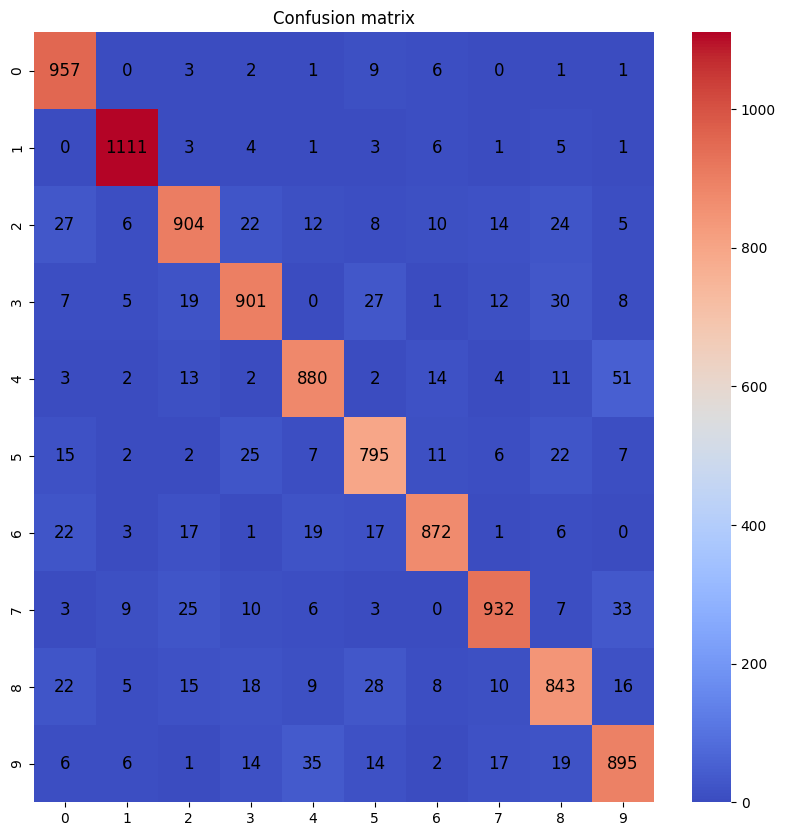

In [ ]:
confusion_matrix_df = pd.DataFrame(conf_matrix)

annot_kws = {"fontsize": 12, "color": "black"}

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix,
            cmap='coolwarm',
            annot= True,
            fmt='d',
            annot_kws=annot_kws
            )

plt.title('Confusion matrix')
plt.show()

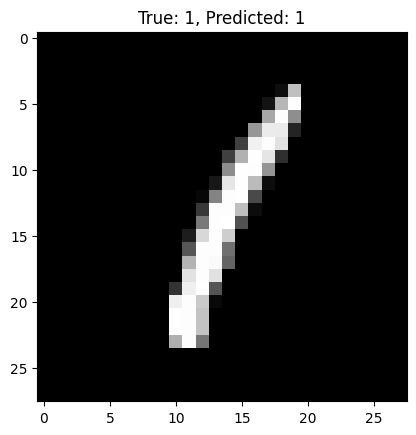

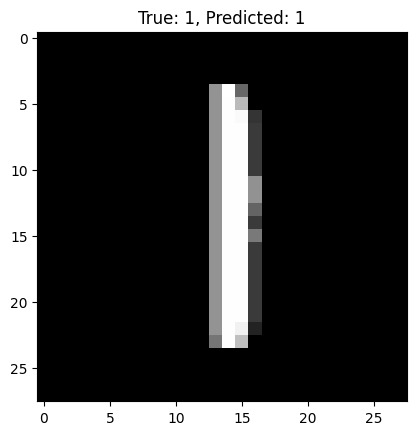

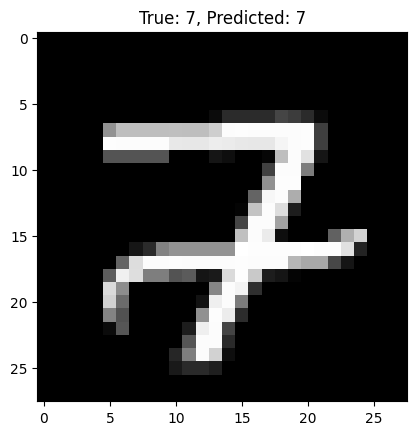

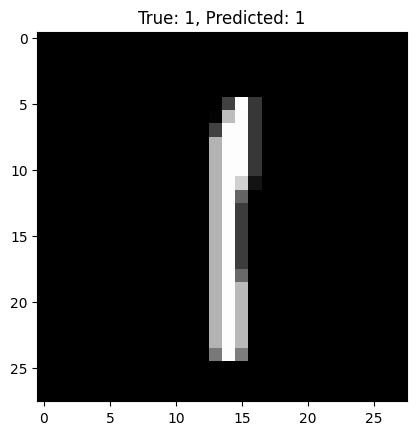

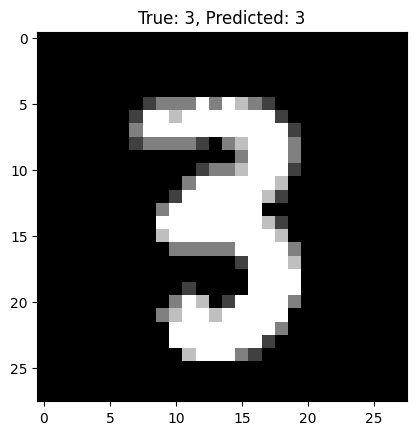

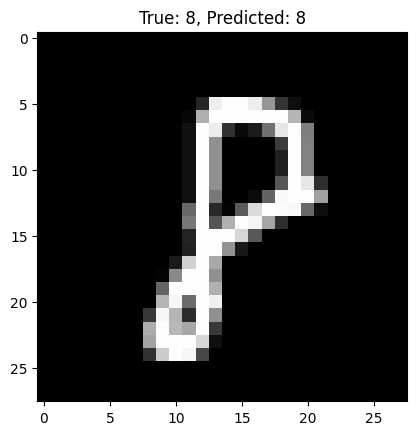

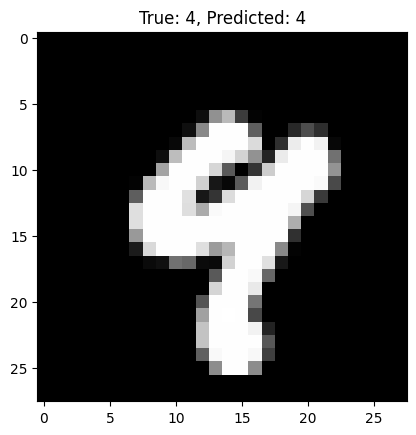

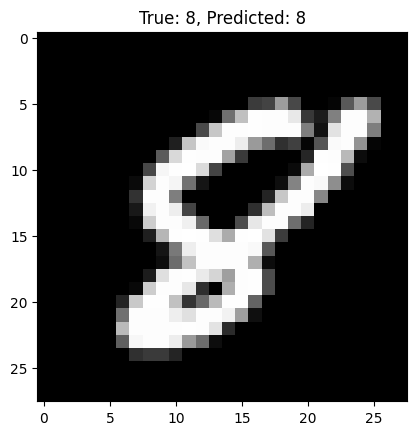

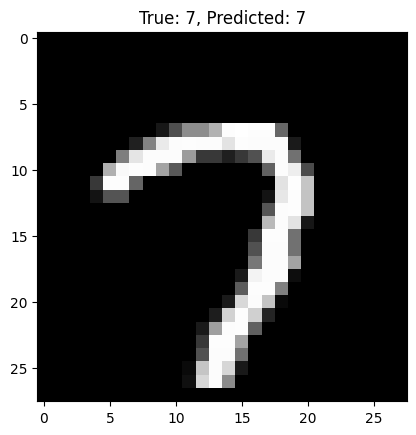

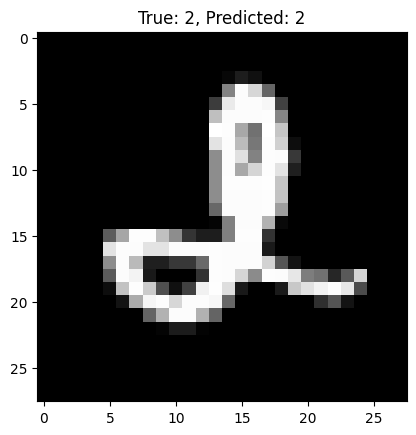

In [ ]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

for i in range(10):
    idx = random.randint(0, x_test.shape[0] - 1)
    img = x_test[idx].reshape((28, 28))
    pred = tf.argmax(neural_net(x_test[idx:idx+1]), axis=1).numpy()[0]
    true = y_test[idx]

    plt.imshow(img, cmap="gray")
    plt.title(f"True: {true}, Predicted: {pred}")
    plt.show()

    if pred != true:
        print(f"Missclassified example index: {idx}, True: {true}, Predicted: {pred}")


